---
# Hemifield experiment: RSA

In [1]:
import os
import json
import pickle
import sys
import nibabel as nb
from sklearn.preprocessing import normalize
from nitime.timeseries import TimeSeries
from nitime.analysis import SpectralAnalyzer, FilterAnalyzer, NormalizationAnalyzer
from linescanning.bin.utils.utils import format_graph
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# import hrf_estimation
import scipy.signal as signal
import scipy.stats as ss
import scipy.ndimage as ndimage

from joblib import Parallel, delayed
import scipy.io as io
import csv
from prfpy.timecourse import sgfilter_predictions
import pathlib

from linescanning import *
base, place = utils.get_base_dir()

base_dir = os.path.join(base, 'projects', 'hemifield')
model_dir = os.path.join(base_dir, 'derivatives', 'model_fitting')

pathlib.Path(model_dir).mkdir(parents=True, exist_ok=True)
np.set_printoptions(precision=8)

/mnt/d/FSL/shared/spinoza/programs/packages/prfpy/prfpy/model.py:5: UserWarning: 

 | Using Nistats with Nilearn versions >= 0.7.0 is redundant and potentially conflicting.
 | Nilearn versions 0.7.0 and up offer all the functionality of Nistats as well the latest features and fixes.
 | We strongly recommend uninstalling Nistats and using Nilearn's stats & reporting modules.

  from nistats.hemodynamic_models import spm_hrf, spm_time_derivative, spm_dispersion_derivative


In [2]:
class ParseExpToolsFile(object):

    """
ParseExpToolsFile()

Class for parsing tsv-files created during experiments with Exptools2. The class will read in the file, 
read when the experiment actually started, correct onset times for this start time and time deleted because
of removing the first few volumes (to do this correctly, set the `TR` and `delete_vols`). You can also pro-
vide a numpy array/file containing eye blinks that should be added to the onset times in real-world time 
(seconds). In principle, it will return a pandas DataFrame indexed by subject and run that can be easily 
concatenated over runs. 

This function relies on the naming used when programming the experiment. In the `session.py` file, you 
should have created `phase_names=['iti', 'stim']`; the class will use these things to parse the file.

Arguments:
    <tsv_file>          : str
                        path pointing to the output file of the experiment

    <subject>           : int
                        subject number in the returned pandas DataFrame (should start with 1, ..., n)
    
    <run>               : int
                        subject number in the returned pandas DataFrame (should start with 1, ..., n)

    <button>            : bool
                        boolean whether to include onset times of button responses (default is false)

    <blinks>            : str|np.ndarray
                        string or array containing the onset times of eye blinks as extracted with hedfpy

    <TR>                : float
                        repetition time to correct onset times for deleted volumes

    <dekete_vols>       : int
                        number of volumes to delete to correct onset times for deleted volumes

Usage:
    In [1]: from linescanning.utils import ParseExpToolsFile
    In [2]: file = 'some/path/to/exptoolsfile.tsv'
    In [3]: parsed_file = ParseExpToolsFile(file, subject=1, run=1, button=True)
    In [4]: onsets = parsed_file.get_onset_df()

Example:
    If you want to get all your subjects and runs in 1 nideconv compatible dataframe, you can do 
    something like this:

    onsets = []
    run_subjects = ['001','002','003']
    for sub in run_subjects:
        path_tsv_files = os.path.join(f'some/path/sub-{sub}')
        f = os.listdir(path_tsv_files)
        nr_runs = []; [nr_runs.append(os.path.join(path_tsv_files, r)) for r in f if "events.tsv" in r]

        for run in range(1,len(nr_runs)+1):
            sub_idx = run_subjects.index(sub)+1
            onsets.append(ParseExpToolsFile(df_onsets, subject=sub_idx, run=run).get_onset_df())
            
    onsets = pd.concat(onsets).set_index(['subject', 'run', 'event_type'])

    """

    def __init__(self, tsv_file, subject=1, run=1, button=False, blinks=None, TR=0.105, delete_vols=38):
        """Initialize object and do all of the parsing/correction/reading"""

        import pandas as pd
        import numpy as np

        self.subject = int(subject)
        self.run = int(run)
        self.deleted_volumes = delete_vols
        self.TR = TR
        self.delete_time = self.deleted_volumes*self.TR

        data_onsets = []
        with open(tsv_file) as f:
            timings = pd.read_csv(f, delimiter='\t')
            data_onsets.append(pd.DataFrame(timings))

        self.data = data_onsets[0]
        self.start_times = pd.DataFrame(self.data[(self.data['response'] == 't') & (
            self.data['trial_nr'] == 1) & (self.data['phase'] == 0)][['onset']])
        self.data_cut_start = self.data.drop(
            [q for q in np.arange(0, self.start_times.index[0])])
        self.onset_times = pd.DataFrame(self.data_cut_start[(self.data_cut_start['event_type'] == 'stim') & (
            self.data_cut_start['condition'].notnull()) | (self.data_cut_start['response'] == 'b')][['onset', 'condition']]['onset'])
        self.condition = pd.DataFrame(self.data_cut_start[(self.data_cut_start['event_type'] == 'stim') & (
            self.data_cut_start['condition'].notnull()) | (self.data_cut_start['response'] == 'b')]['condition'])

        # add button presses
        if button:
            self.response = self.data_cut_start[(
                self.data_cut_start['response'] == 'b')]
            self.condition.loc[self.response.index] = 'response'

        self.onset = np.concatenate((self.onset_times, self.condition), axis=1)

        # add eyeblinks
        if isinstance(blinks, np.ndarray) or isinstance(blinks, str):
            if isinstance(blinks, np.ndarray):
                self.eye_blinks = blinks
            elif isinstance(blinks, str):
                if blinks.endwith(".npy"):
                    self.eye_blinks = np.load(blinks)
                else:
                    raise ValueError(
                        f"Could not recognize type of {blinks}. Should be numpy array or string to numpy file")

            self.eye_blinks = self.eye_blinks.astype('object').flatten()
            tmp = self.onset[:, 0].flatten()

            # combine and sort timings
            comb = np.concatenate((self.eye_blinks, tmp))
            comb = np.sort(comb)[..., np.newaxis]

            # add back event types by checking timing values in both arrays
            event_array = []
            for ii in comb:

                if ii in self.onset:
                    idx = np.where(self.onset == ii)[0][0]
                    event_array.append(self.onset[idx][-1])
                else:
                    idx = np.where(self.eye_blinks == ii)[0]
                    event_array.append('blink')

            event_array = np.array(event_array)[..., np.newaxis]

            self.onset = np.concatenate((comb, event_array), axis=1)

        # correct for start time of experiment and deleted time due to removal of inital volumes
        self.onset[:, 0] = self.onset[:, 0] - \
            float(self.start_times['onset'] + self.delete_time)

        # create nideconv-compatible dataframe
        self.onset_df = pd.DataFrame(
            self.onset, columns=['onset', 'event_type'])
        self.onset_df['subject'], self.onset_df['run'] = self.subject, self.run
        self.onset_df = self.onset_df.astype(
            {"onset": float, "event_type": str})

    def get_onset_df(self):
        """Return the indexed DataFrame containing onset times"""
        return self.onset_df

    def onsets_to_txt(self, subject=1, run=1, condition='right', fname=None):
        """
    onset_to_txt

    This function creates a text file with a single column containing the onset times of a given condition.
    Such a file can be used for SPM or FSL modeling, but it should be noted that the onset times have been 
    corrected for the deleted volumes at the beginning. So make sure your inputting the correct functional
    data in these cases.

    Arguments:
        <subject>       : int
                        subject number you'd like to have the onset times for    
        <run>           : int
                        run number you'd like to have the onset times for
        
        <condition>     : str
                        name of the condition you'd like to have the onset times for as specified in the data
                        frame

        <fname>         : str
                        path to output name for text file

        """

        import numpy as np
        df = self.onset_df.set_index(['subject', 'run', 'event_type'])
        onsets = list(df['onset'][subject][run]
                      [condition].to_numpy().flatten().T)
        np.savetxt(fname, onsets, fmt='%1.3f')

    def onsets_to_list(self, subject=1, run=1, condition='right'):
        """similar to onsets_to_txt, but returns a list instead of outputting a text file"""
        import numpy as np
        df = self.onset_df.set_index(['subject', 'run', 'event_type'])
        onsets = list(df['onset'][subject][run]
                      [condition].to_numpy().flatten().T)

        return onsets


In [3]:
# run_subjects = ['001', '005', '006']
run_subjects = ['003']
session = "ses-2"

TR = 0.105
deleted_first_timepoints = 38
deleted_last_timepoints = 38

initial_deleted_time = TR * deleted_first_timepoints

include_eye = True
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/TR

hp = 0.01
lp = 8.0
butter_order = 3
sg_filter_length = 2001

data_psc = []
data_zscore = []
onsets = []

# Create data frames per subject and run
########################################

for sub in run_subjects:

    print("\n------------------------------ processing {sub} ------------------------------".format(sub=f'sub-{sub}'))

    subject = f'sub-{sub}'
    session_dir = os.path.join(base_dir, subject, session, 'func')
    f = os.listdir(session_dir)
    nr_runs = []
    [nr_runs.append(os.path.join(session_dir, r))
     for r in f if "bold.mat" in r]

    if len(nr_runs) != 0:

        for run in range(1, len(nr_runs)+1):

            print(f"  dealing with run-{run}")

            sub_idx = run_subjects.index(sub)+1

            # data_onsets = []
            df_onsets = os.path.join(session_dir, f'{subject}_{session}_task-LR_run-{run}_events.tsv')

            # load everything in with ParseExpToolsFile
            onsets.append(ParseExpToolsFile(df_onsets, subject=sub_idx, run=run).get_onset_df())

            # TIME SERIES STUFF
            ###################

            # Load in datasets with tag "wcsmtSNR"
            ts_wcsmtSNR = io.loadmat(os.path.join(
                session_dir, f'{subject}_{session}_task-LR_run-{run}_bold.mat'))['Data_wcsmtSNR']
            ts_complex = ts_wcsmtSNR
            ts_magnitude = np.abs(ts_wcsmtSNR)

            # trim beginning and end
            # ts_corrected = ts_magnitude[:,deleted_first_timepoints:-deleted_last_timepoints]
            ts_corrected = ts_magnitude[:, deleted_first_timepoints:]

            # sklearn filtering?
            T = TimeSeries(ts_corrected, sampling_interval=TR)
            F = FilterAnalyzer(T, ub=0.15, lb=0.02)
            psc = NormalizationAnalyzer(F.filtered_boxcar).percent_change.data
            zscore = NormalizationAnalyzer(F.filtered_boxcar).z_score.data

            vox_cols = [f'vox {x}' for x in range(zscore.shape[0])]

            mixed_zscore = pd.DataFrame(zscore.T, columns=vox_cols)
            mixed_psc = pd.DataFrame(psc.T, columns=vox_cols)

            mixed_zscore['subject'], mixed_zscore['run'], mixed_zscore['t'] = sub_idx, run, list(
                TR*np.arange(zscore.shape[-1]))
            mixed_psc['subject'], mixed_psc['run'], mixed_psc['t'] = sub_idx, run, list(
                TR*np.arange(psc.shape[-1]))

            data_zscore.append(mixed_zscore)
            data_psc.append(mixed_psc)
            # onsets.append(mixed_onsets2)

pathlib.Path(os.path.join(model_dir, subject, 'ses-2')).mkdir(parents=True, exist_ok=True) # ; onsets.to_csv(os.path.join(model_dir, subject, 'ses-2', f'{subject}_ses-2_desc-onsets.csv'))
onsets = pd.concat(onsets).set_index(['subject', 'run', 'event_type']) # ; data_zscore.to_csv(os.path.join(model_dir, subject, 'ses-2', f'{subject}_ses-2_desc-timecourses_zscore.csv'))
data_zscore = pd.concat(data_zscore).set_index(['subject', 'run', 't']) # ; data_psc.to_csv(os.path.join(model_dir, subject, 'ses-2', f'{subject}_ses-2_desc-timecourses_psc.csv'))
data_psc = pd.concat(data_psc).set_index(['subject', 'run', 't'])

print('\nDone')


------------------------------ processing sub-003 ------------------------------
  dealing with run-1
  dealing with run-2
  dealing with run-3
  dealing with run-4

Done


---
# Representational Similarity Analysis

In [12]:
from nilearn.glm.first_level import make_first_level_design_matrix

events = onsets.iloc[onsets.index.get_level_values('run') == 1].reset_index()['onset'].values
events_sim = pd.DataFrame(events, columns=['onset'])
events_sim.loc[:, 'duration'] = 1
events_sim.loc[:, 'trial_type'] = ['trial_' + str(i).zfill(2) for i in range(1, events.shape[0]+1)]

ts = data_zscore.iloc[data_zscore.index.get_level_values('run') == 1].values[:,(360-5):(360+5)]
frame_times = TR * (np.arange(ts.shape[0]))

# lsa_dm = least squares all design matrix
lsa_dm = make_first_level_design_matrix(
    frame_times=frame_times,  # we defined this earlier for interpolation!
    events=events_sim,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

# lsa_dm


<AxesSubplot:label='conditions', ylabel='scan number'>

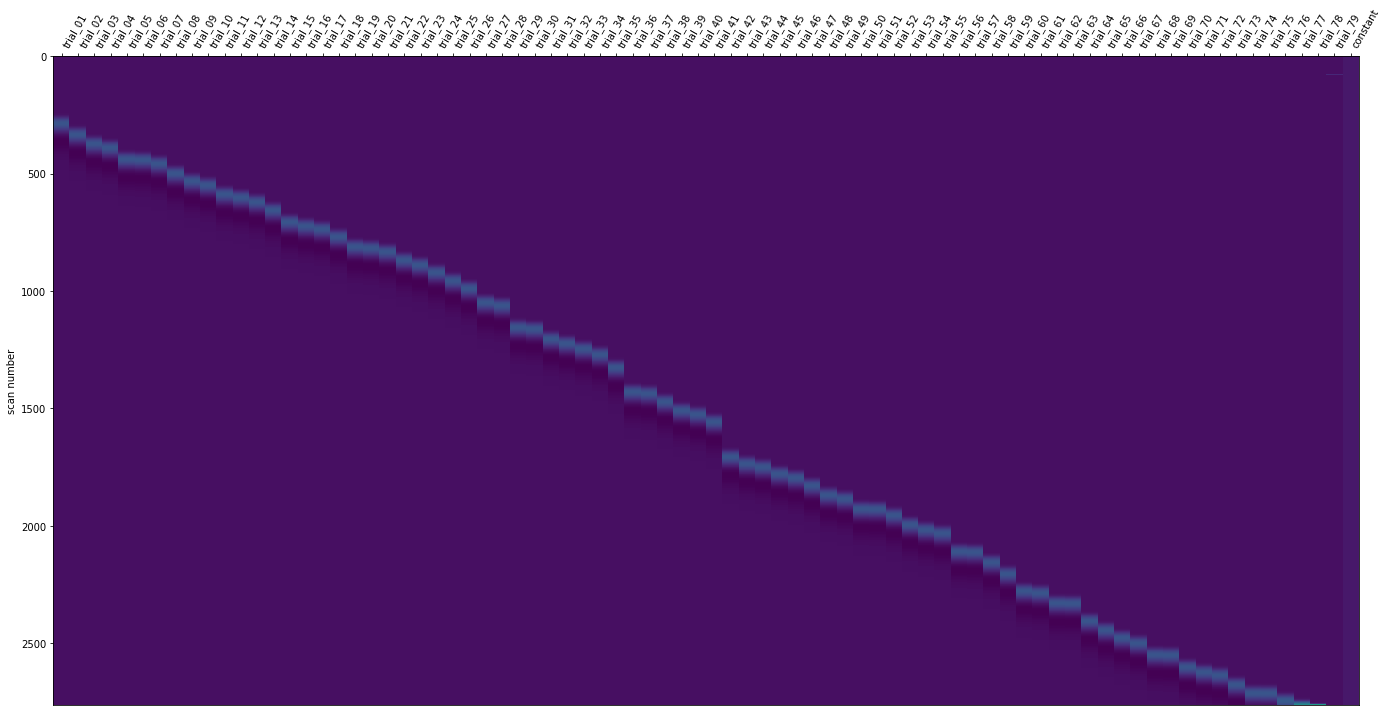

In [7]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(lsa_dm)

In [13]:
# Let's use 'X', because it's shorter
X = lsa_dm.values

# Note we can fit our GLM for all K voxels at
# the same time! As such, betas is not a vector,
# but an n_regressor x k_voxel matrix!
beta_hat_all = np.linalg.inv(X.T @ X) @ X.T @ ts
print("Shape beta_hat_all:", beta_hat_all.shape)

# Ah, the beta for the intercept is still in there
# Let's remove it
beta_icept = beta_hat_all[-1, :]
beta_hat = beta_hat_all[:-1, :]
print("Shape beta_hat (intercept removed):", beta_hat.shape)

Shape beta_hat_all: (80, 10)
Shape beta_hat (intercept removed): (79, 10)


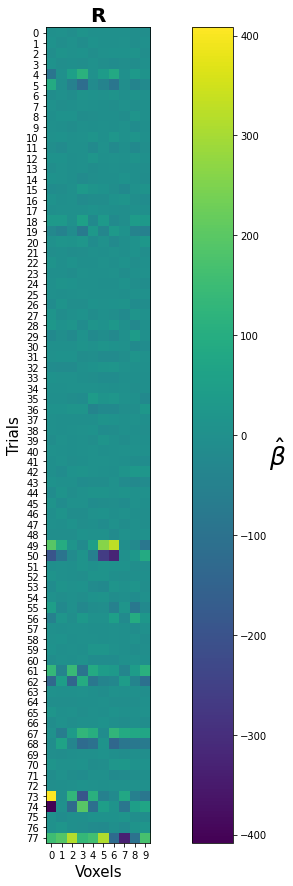

In [17]:
fig, ax = plt.subplots(figsize=(15, 15))
mapp = ax.imshow(beta_hat[:-1, :])
cbar = fig.colorbar(mapp)
cbar.set_label(r'$\hat{\beta}$', fontsize=25, rotation=0, labelpad=10)
ax.set_yticks(np.arange(beta_hat[:-1, :].shape[0]))
ax.set_xticks(np.arange(beta_hat[:-1, :].shape[1]))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()
